## Copy these cells to make your own queries

In [1]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

from sklearn.linear_model import LinearRegression

%matplotlib inline

# Introduction

**Contents:**

*Pre-processing*

Data Inspection


*Analysis*

1. Temporal trends: Look at monthly/seasonal trends to detect seasonality in sales and products purchased.

2. Customer behavior: What are the common actions leading to purchases, and who are our most engaged customers?

3. Key factors: Investigate factors like pageviews, timeOnSite, and price affecting purchase decisions.

# **1. Investigate Temporal Trends**

### How do sales vary across the year?

In [2]:
%run "../../../Data Cleaning/bigquery_loader.py"

e:\GitHub\DSA3101-E-commerce\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.

e:\GitHub\DSA3101-E-commerce\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



<Axes: title={'center': 'Sales Trend between Aug 2016 & Aug 2017'}, xlabel='Month', ylabel='Total Revenue'>

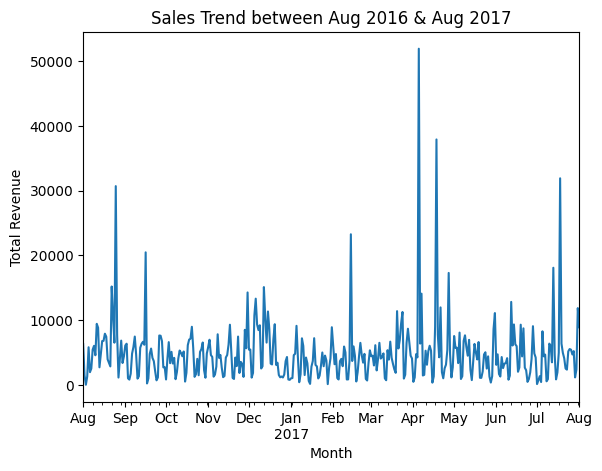

In [3]:
sales_over_time = total_revenue.groupby('date')['total_revenue'].sum()

# Visualize sales trends
sales_over_time.plot(title='Sales Trend between Aug 2016 & Aug 2017', xlabel='Month', ylabel='Total Revenue')

<Axes: title={'center': 'Monthly Sales Trend'}, xlabel='Month', ylabel='Total Revenue'>

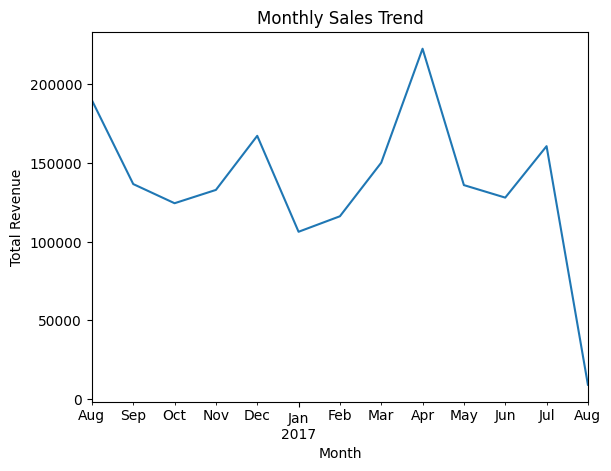

In [4]:
sales_over_time = total_revenue.groupby(total_revenue['date'].dt.to_period('M'))['total_revenue'].sum()
# Visualize sales trends
sales_over_time.plot(title='Monthly Sales Trend', xlabel='Month', ylabel='Total Revenue')

**Aggregate sales by category:**

Using the total sales and number of transactions per month for each category combination (main_category, sub_category, subsub_category), we find the sum of transactions and total_revenue to analyze sales trends for each category.

**Detect trends:**

Look at monthly patterns of sales in each product category a line plot to visualize trends across months and years.

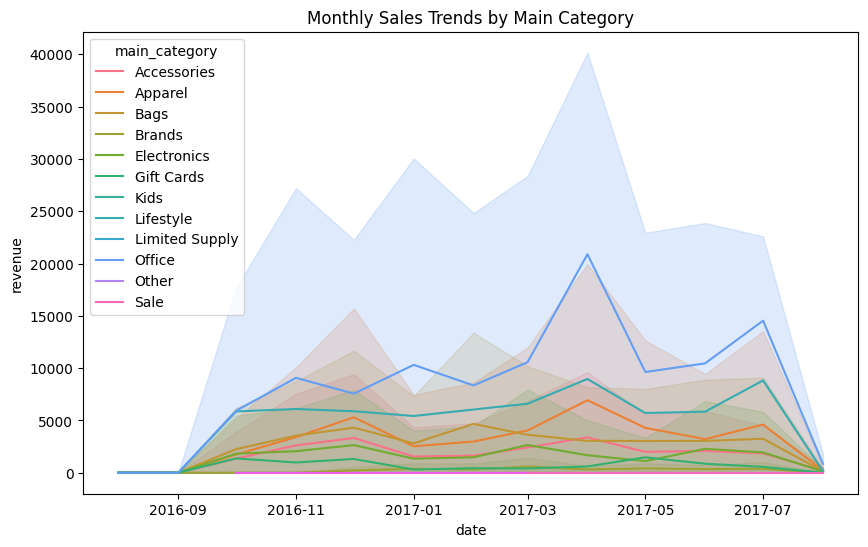

In [6]:
plt.figure(figsize=(10,6))
sns.lineplot(data=agg_sales_by_cat[agg_sales_by_cat['main_category'] != 'Unavailable'], x='date', y='revenue', hue='main_category')
plt.title('Monthly Sales Trends by Main Category')
plt.show()

**Identify popular categories by month:**

To find popular categories in different months, we sort the monthly aggregated data by totals_revenue and look at the top-selling categories in each month. This will give us a list of the top 3 selling categories for each month, which will help in understanding which categories are more popular during specific times of the year.

In [7]:
agg_sales_by_cat

,date,main_category,sub_category,subsub_category,transaction_count,revenue
0,2016-08-01,Accessories,Drinkware,Other,9591,0.000000
1,2016-08-01,Accessories,Fun,Other,3875,0.000000
2,2016-08-01,Accessories,Other,Other,50,0.000000
3,2016-08-01,Accessories,Stickers,Other,434,0.000000
4,2016-08-01,Apparel,Headgear,Other,133,0.000000
...,...,...,...,...,...,...
557,2017-08-01,Office,Notebooks & Journals,Other,81,1770.731110
558,2017-08-01,Office,Other,Other,132,781.480170
559,2017-08-01,Office,Writing,Other,40,0.000000
560,2017-08-01,Sale,Clearance,Other,14,0.000000


In [9]:
popular_categories = agg_sales_by_cat.groupby('date').apply(lambda x: x.nlargest(3, 'revenue'), include_groups = True).reset_index(drop=True)

C:\Users\user\AppData\Local\Temp\ipykernel_45224\2107013700.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



# **2. Analyze Customer Purchasing Behavior**

### **What are the common actions leading to purchases, and who are our most engaged customers?**

(a) Check how often users make purchases by exploring user engagement (visitNumber, action for purchases, etc.).

Total Purchases per User: Identify the most engaged customers by counting the number of purchases they’ve made (action = 6 means completed purchase).

Total Revenue: Calculate the revenue generated from each customer to identify high-priority customers.

In [10]:
query = '''
SELECT
  fullVisitorId AS users,
  COUNT(DISTINCT hits.transaction.transactionId) AS total_purchases,
  SUM(IFNULL(hits.transaction.transactionRevenue / 1e6, 0)) AS total_revenue
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  AND
    hits.eCommerceAction.action_type = '6'
GROUP BY
  fullVisitorId
'''

purchases_per_user = client.query(query).result().to_dataframe()
print(purchases_per_user.describe())

e:\GitHub\DSA3101-E-commerce\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



       total_purchases  total_revenue
count          10022.0   10022.000000
mean          1.152664     177.890863
std           0.716494    1435.894057
min                1.0       0.000000
25%                1.0      29.612500
50%                1.0      55.080000
75%                1.0     117.032500
max               33.0  128446.520000


To understand purchase behavior (i.e. action = 6), we will identify key metrics that differentiate purchasing customers (action = 6) from non-purchasing customers. We will focus on the following:

VisitNumber: How many visits did it take for the customer to make a purchase? Do customers who purchase on the first visit behave differently than those who purchase on subsequent visits?

TimeOnSite: How much time did customers who made a purchase spend on the site compared to those who did not?

Pageviews: How many pages did purchasing customers view on average compared to non-purchasing customers?

We will calculate average values of these metrics for customers who completed an action (action = 6) vs. those who did not.

In [11]:
query = '''
WITH visitsWithPurchases AS (
  SELECT
    fullVisitorId AS users,
    visitId
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  AND
    hits.eCommerceAction.action_type = '6'
)

SELECT
    CASE
        WHEN p.visitId IS NOT NULL THEN 'Purchase'
        ELSE 'No Purchase'
    END AS visit_type,
    AVG(visitNumber) AS average_visit_no,
    AVG(totals.timeOnSite) AS avg_time,
    AVG(totals.pageviews) AS avg_pgviews
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*` v
LEFT JOIN
    visitsWithPurchases p
ON
    v.fullVisitorId = p.users
    AND v.visitId = p.visitId
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
GROUP BY visit_type
'''

purchase_averages = client.query(query).result().to_dataframe()
print(purchase_averages)

e:\GitHub\DSA3101-E-commerce\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



    visit_type  average_visit_no     avg_time  avg_pgviews
0  No Purchase          2.241291   241.582698     3.531661
1     Purchase          4.262106  1167.344332    32.214210


To identify the most engaged customers who spent the most time on the site, viewed the most pages, and made the most purchases:

Top customers by timeOnSite: Customers who spent the longest time browsing.

Top customers by pageviews: Customers who viewed the most pages.

Top customers by transactions: Customers who made the most purchases.

In [ ]:
query = '''
SELECT
  fullVisitorId AS users,
  SUM(IFNULL(totals.pageviews, 0)) AS pageviews,
  SUM(IFNULL(totals.timeOnSite, 0)) AS timeOnSite,
  SUM(totals.transactions) AS transactions
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
GROUP BY
  fullVisitorId
ORDER BY
  transactions DESC,
  timeOnSite DESC,
  pageviews DESC
'''

top_customers = client.query(query).result().to_dataframe()

print("Top 10 most engaged customers:")
print(top_customers.head(10))

# **3. Key factors influencing purchases**

## Investigate Key Numerical Features Influencing Purchases

Investigate the correlation of features that are not nested in the table

In [ ]:
query = '''
SELECT
  visitNumber AS visit_number,
  totals.timeOnSite AS time_on_site,
  totals.pageviews AS pageviews,
  totals.hits AS num_hits,
  totals.sessionQualityDim AS session_quality,
  totals.totalTransactionRevenue / 1e6 AS totals_revenue,
  totals.transactions AS transactions
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
'''

res_1 = client.query(query).result().to_dataframe()
res_1['totals_revenue'] = res_1['totals_revenue'].fillna(0)
res_1['session_quality'] = res_1['session_quality'].fillna(-1)
res_1['transactions'] = res_1['transactions'].fillna(0)

In [ ]:
# Calculating correlation matrix
corr_matrix = res_1.corr()

# Plotting correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Investigate the correlation of features that are nested in the table

In [ ]:
query = '''
SELECT
  fullVisitorId AS users,
  hits.eCommerceAction.action_type AS action,
  product.productPrice / 1e6 AS price,
  product.isImpression AS impression,
  product.isClick AS click
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits,
  UNNEST(hits.product) AS product
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
'''

res_2 = client.query(query).result().to_dataframe()

In [ ]:
res_2['action'] = res_2['action'].apply(int)
res_2['click'] = res_2['click'].apply(lambda x: 1 if x is True else 0)
res_2['impression'] = res_2['impression'].apply(lambda x: 1 if x is True else 0)

In [ ]:
corr_matrix = res_2.loc[:, res_2.columns != 'users'].corr()

# Plotting correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**Insights from Correlation Matrix:**

Features like transactions, pageviews, numHits, timeOnSite, action, and visitNumber has larger than 0.1 correlation with totals_revenue, arranged from highest to lowest correlation.

1. 'transactions' represent the total number of ecommerce transactions within each user session. Hence, it is natural to have 0.3 correlation with 'totals_revenue'

2. 'pageviews' represent the total number of page views in each user session. It has a 0.21 correlation with 'totals_revenue' and a 0.45 correlation with 'transactions'. This might imply customers who view more pages have a stronger desire to shop.

3. 'numHits' represent the total number of hits within each user session. Since it has similar meaning as 'pageviews' and the correlation between them is 0.98, we only need to choose 1 out of the 2 features. Correlation between 'numHits' and 'totals_revenue', 'transactions' are 0.19 and 0.4 respectively.

4. 'timeOnSite' represents total time of the session expressed in seconds. It has a 0.16 and 0.33 correlation with 'totals_revenue' and 'transactions' respectively.

5. 'action'. Conversion funnel analysis will be done.

6. 'visitNumber' is the number of times a particular user initiates a session within our e-commerce site. It has a 0.11 correlation with 'totals_revenue' but 0.024 correlation with 'transactions'.

7. 'price' has very minimal positive correlation with 'totals_revenue' and 'transactions'.

***Steps:***

(i) Deep dive into relationship between transactions and revenue (correlation obtained is smaller than expected)

(ii) Explore customer engagement via Pageviews and Time on Site

(iii) Analyze Conversion Funnel via Action Types

(iv) Analyze Visit Number Impact

(v) Analyze customer Price Sensitivity

(vi) Exclude numHits from subsequent analysis

### (i) Linear Regression between 'totals_revenue' and 'transactions'

In [ ]:
X, y = res_1['transactions'], res_1['totals_revenue']
X = X.values.reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)
print(f"Transaction Impact on Revenue: {model.coef_}")

This shows that an additional transaction will contribute to approximately $156.68 revenue.

### (ii) Explore customer engagement (pageviews, timeOnSite)

`pageviews` and `time_on_site` are engagement metrics that influence customer purchases. We want to investigate whether higher engagement leads to more purchases by visualizing how these metrics relate to `transactions` and `totals_revenue`.

In [ ]:
plt.subplot(1,2,1)
sns.scatterplot(x='pageviews', y='transactions', data=res_1)
plt.title('Pageviews vs Transactions')
plt.show()

plt.subplot(1,2,2)
sns.scatterplot(x='time_on_site', y='transactions', data=res_1)
plt.title('Time on Site vs Transactions')
plt.show()

It seems like for longer `time_on_site`, customer tendency to transact is higher. This can be seen by decreasing number of datapoints clustered at the lower part of the graph, especially at the lower left corner. Number of dots seem to be consistent for each `time_on_site` from 0~6000 seconds. But there seem to be an upward dispersion trend of dots. This observation is the same for `pageviews` graph.

### (iii) Analyzing Conversion Funnel via Action Types

The action variable captures customer behaviors across different stages of the purchase funnel (from product views to completed purchases).

We will perform an elementary conversion funnel analysis to understand drop-offs between stages. For example, how many users add products to the cart but don’t complete the purchase?

In [ ]:
action_counts = res_2['action'][res_2['action']!=0].value_counts()
action_counts.plot(kind='bar')
plt.title('Distribution of Customer Actions')
plt.show()

**We note that here's how different actions are encoded:**

1: Click through of product lists

2: Product detail views

3: Add product(s) to cart

4: Remove product(s) from cart

5: Check out

6: Completed purchase


**There are 2 possible train of actions a customer may take to get to stage '6'**

(i) 1 -> 2 -> 3 -> 5 -> 6

(ii) 1 -> 2 -> 5 -> 6

Note: Not all users add to cart before purchasing. They can purchase directly from the product listing page.

**In particular, we are interested in understanding the conversion rate from action 1 -> 2 ; 2 -> 5 ; 5 -> 6:**

In [ ]:
#  Calculate the total number of users at each stage
funnel = res_2.groupby('action')['users'].nunique()
rates = {'steps':[],
         'conversion_rates':[]}

# Calculate conversion rate from clicks (action=1) to product view (action=2)
conversion_rate = (funnel[2] / funnel[1]) * 100
rates['steps'].append('Product List Clicks')
rates['conversion_rates'].append(conversion_rate)
print(f"Conversion rate from product list clicking to product detail views: {conversion_rate:.2f}%")

# Calculate conversion rate from product view (action=2) to checkout (action=5)
conversion_rate = (funnel[5] / funnel[2]) * 100
rates['steps'].append('Product Detail Views')
rates['conversion_rates'].append(conversion_rate)
print(f"Conversion rate from product detail views to checkout: {conversion_rate:.2f}%")

# Calculate conversion rate from checkout (action=5) to completed purchase (action=6)
conversion_rate = (funnel[6] / funnel[5]) * 100
rates['steps'].append('Checkout')
rates['conversion_rates'].append(conversion_rate)
print(f"Conversion rate from checkout to completed purchase: {conversion_rate:.2f}%")

# Investigate the percentage of customers who abandon their carts (action=3 to action=4)
conversion_rate = (funnel[4] / funnel[3]) * 100
print(f"Percentage of customers who abandon their carts: {conversion_rate:.2f}%")

In [ ]:
# Conversion rates
rates = pd.DataFrame.from_dict(rates)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Draw funnel
ax.barh(rates['steps'], rates['conversion_rates'], color=['#00A86B', '#3CB371', '#98FB98'], edgecolor='black')

# Label the values
for i, v in enumerate(rates['conversion_rates']):
    ax.text(v + 2, i, f"{v:.2f}%", color='black', va='center', fontsize=12)

# Add some labels and title
ax.set_xlabel('Conversion Rate (%)')
ax.set_title('E-Commerce Conversion Funnel', fontsize=16)
ax.invert_yaxis()  # Reverse the order to have the highest on top

# Display the funnel plot
plt.tight_layout()
plt.show()

- We can see most users drop off at action 2, which is product detail viewing. Can we offer discounts to customers who stays on the site more than 120 seconds?

- There is also almost 50% drop-off rate at the checkout stage. Can we offer them targeted discounts? e.g. discount for the items they were trying to checkout.

- 20% of the customers abandon their carts. Can discount vouchers be offered too?

### **(iv) Analyzing Visit Number Impact**

- visitNumber has a lower correlation with totals_revenue (0.11) and even lower with transactions (0.024). This suggests that repeat visits don’t always guarantee higher revenue.

- Hence, we are incentivized to investigate first-time vs repeat customers. Analyze if first-time visitors or returning customers contribute more to revenue. If repeat visitors show low conversions, consider launching targeted re-engagement campaigns.

***To analyze the revenue contribution of first-time visitors versus returning customers based on the visitNumber, we can categorize visitNumber into three groups:***

1. First-time visitors (visitNumber = 1)

2. Occasional visitors (1 < visitNumber ≤ 5)

3. Frequent visitors (visitNumber > 5)

This analysis will help us assess which group contributes the most to revenue and whether repeat visitors show low conversion, prompting potential re-engagement strategies.

***Steps:***

1. Create Categories for Visitors: We’ll create a new column visitor_category based on the criteria provided for visitNumber.

2. Calculate Average Revenue per Group: We’ll group by the visitor_category and calculate the mean and total revenue for each group.

3. Compare Conversion Rates: Using transactions as a proxy for conversions, we’ll compare the conversion rate across visitor categories.

4. Interpret Findings: Depending on the results, we can suggest re-engagement campaigns for visitors with low conversion rates.

In [ ]:
res_1.dtypes

In [ ]:
# Create a new column 'visitor_category'
res_1['visitor_category'] = pd.cut(res_1['visit_number'],
                                bins=[0, 1, 5, res_1['visit_number'].max()],
                                labels=['First-time', 'Occasional', 'Frequent'],
                                include_lowest=True)

# Group by visitor_category and calculate mean and total revenue
revenue_stats = res_1.groupby('visitor_category', observed = True)['totals_revenue'].agg(['mean', 'sum']).reset_index()

# Calculate conversion rates (based on transactions)
conversion_stats = res_1.groupby('visitor_category', observed = True)['transactions'].agg(['mean', 'sum']).reset_index()

# Merge the results
stats = pd.merge(revenue_stats, conversion_stats, on='visitor_category')
stats.rename(columns={"mean_x": "Mean Revenue", "sum_x": "Total Revenue",
                      "mean_y": "Mean Transactions", "sum_y": "Total Transactions"})

# Print or visualize the result
print(stats)


- Revenue contribution: Frequent visitors dominate, loyalty programs may be beneficial.

- Conversion rates: Occasional or frequent visitors show moderate conversions, with that of frequent visitors being higher. There is room for improvement. Consider re-engagement campaigns to increase their engagement and conversion rates.

### **(v) Analyzing Customer Price Sensitivity**

##### (a) Plotting Distribution of Price-Sensitivity according to customer's Average Order Value

In [ ]:
query = '''
SELECT
  *,
  CASE
      WHEN avg_order_value < 10 THEN 'Price-Sensitive'
      WHEN avg_order_value BETWEEN 10 AND 20 THEN 'Semi Price-Sensitive'
      WHEN avg_order_value BETWEEN 20 AND 50 THEN 'Medium Price-Sensitive'
      WHEN avg_order_value BETWEEN 50 AND 100 THEN 'Semi-Low Price-Sensitive'
      ELSE 'Low-Sensitivity'
    END AS price_sensitivity_segment
  FROM (
SELECT
    fullVisitorId,
    COUNT(DISTINCT hits.transaction.transactionId) AS purchase_count,
    AVG(hits.transaction.transactionRevenue / 1000000) AS avg_order_value,

FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
GROUP BY
    fullVisitorId
)
'''

res_3 = client.query(query).result().to_dataframe()

In [ ]:
res_3['price_sensitivity_segment'].value_counts()

In [ ]:
categories = ['Low-Sensitivity', 'Semi-Low Price-Sensitive', 'Medium Price-Sensitive', 'Semi Price-Sensitive', 'Price-Sensitive' ]

fig, axes = plt.subplots(nrows=len(categories), ncols=1, figsize=(10, 30))
for i, category in enumerate(categories):
    # Filter data for the current category
    category_data = res_3[res_3['price_sensitivity_segment'] == category]

    # Create the distribution plot for the current category
    sns.histplot(category_data['avg_order_value'], kde=True, ax=axes[i])  # Using histplot with KDE

    # Set the title for each subplot
    axes[i].set_title(f'Distribution of Total Revenue - {category}')
    axes[i].set_xlabel('Total Revenue')
    axes[i].set_ylabel('Frequency')

## Investigate Key Categorical Features influencing Purchases

Analyze the contribution of different customer segments (by region, product categories, etc.) to totals_revenue and transactions to identify key drivers and potential opportunities for optimizing revenue or conversion rates.

### **(i) Region**

Analyze revenue or transactions by continent, subcontinent, and country to understand geographical patterns.

In [ ]:
query = '''
SELECT
  geoNetwork.continent AS continent,
  geoNetwork.subContinent AS subcontinent,
  geoNetwork.country AS country,
  SUM(totals.totalTransactionRevenue / 1e6) AS total_revenue,
  SUM(totals.transactions) AS total_transactions
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
GROUP BY
  continent, subcontinent, country
'''

res_4 = client.query(query).result().to_dataframe()
res_4b = res_4.copy()[['continent', 'total_revenue']]
res_4b = res_4b.groupby('continent').sum()
res_4b

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(data=res_4b, x='continent', y='total_revenue')
plt.title('Revenue by Continent')
plt.show()

From the graph, we see that the Americas generate the most revenue. We now want to investigate the countries generating the most revenue.

In [ ]:
# Revenue by country
res_4['revenue_percent'] = res_4['total_revenue'] / res_4['total_revenue'].sum() * 100
res_4[['country', 'total_revenue', 'revenue_percent']].sort_values(by='total_revenue', ascending=False).head(10)

We see that the United States contributes to 93.49% of all revenue, followed by Venezuela at 2.03%.

In [ ]:
# Transactions by country
res_4['trans_percent'] = res_4['total_transactions'] / res_4['total_transactions'].sum() * 100
res_4[['country', 'total_transactions', 'trans_percent']].sort_values(by='total_transactions', ascending=False).head(10)

We further observe that the United States contribute 94.43% of all transactions.

### **(ii) Product category**

- Main Category -> Explore how different product categories contribute to overall revenue and transaction counts.
- Sub-Category -> Dive deeper into sub-categories to identify high- and low-performing products.

In [ ]:
query = '''
  SELECT
    product.v2ProductCategory AS product_category,
    COUNT(DISTINCT CONCAT(fullVisitorId, CAST(visitId AS STRING))) AS transaction_count,
    SUM(IFNULL(product.productRevenue / 1e6, 0)) AS revenue
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits,
    UNNEST(hits.product) AS product
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  AND
    totals.transactions IS NOT NULL
  GROUP BY
    product_category
  ORDER BY
    transaction_count DESC, revenue DESC;
'''

res_5 = client.query(query).result().to_dataframe()

In [ ]:
exact_replacements = {
    "Apparel//Men's-T-Shirts": "Apparel/Men's/Men's-T-Shirts",
    'Backpacks': 'Bags/Backpacks',
    'Bottles': 'Accessories/Drinkware/Water Bottles and Tumblers',
    'Drinkware/Bottles': 'Accessories/Drinkware/Water Bottles and Tumblers',
    'Drinkware': 'Accessories/Drinkware',
    'Drinkware/Mugs and Cups': 'Accessories/Drinkware/Mugs and Cups',
    'Drinkware/Water Bottles and Tumblers': 'Accessories/Drinkware/Water Bottles and Tumblers',
    'Electronics/Accessories/Drinkware': 'Accessories/Drinkware',
    'Drinkware/Mugs': 'Accessories/Drinkware/Mugs and Cups',
    'Mugs': 'Accessories/Drinkware/Mugs and Cups',
    'Clearance Sale': 'Sale/Clearance',
    'Spring Sale!': 'Sale/Spring',
    'Fun': 'Accessories/Fun',
    'Fruit Games': 'Accessories/Fun',
    'Lifestyle/Fun': 'Accessories/Fun',
    "Men's-Outerwear": "Apparel/Men's/Men's-Outerwear",
    "Men's/Men's-Performance Wear": "Apparel/Men's/Men's-Performance Wear",
    'Mens Outerwear': "Apparel/Men's/Men's-Outerwear",
    'More Bags': 'Bags/More Bags',
    'Notebooks & Journals': 'Office/Notebooks & Journals',
    'Office/Office Other': 'Office/Other',
    'Office/Writing Instruments': 'Office/Writing',
    'Shop by Brand': 'Brands',
    'Shop by Brand/Google': 'Brands/Google',
    'Shop by Brand/Waze': 'Brands/Waze',
    'Shop by Brand/YouTube': 'Brands/YouTube',
    'Shop by Brand/Android': 'Brands/Android',
    'Google': 'Brands/Google',
    'Housewares': 'Accessories/Housewares',
    'Headgear': 'Apparel/Headgear',
    'Headwear': 'Apparel/Headwear',
    'Home': '',
    'Tumblers': 'Accessories/Drinkware/Water Bottles and Tumblers',
    'Waze': 'Brands/Waze',
    'Wearables': 'Apparel',
    "Wearables/Men's T-Shirts": "Apparel/Men's/Men's-T-Shirts",
    'Writing': 'Office/Writing',
    'YouTube': 'Brands/Youtube',
    'Android': 'Brands/Android',
}

In [ ]:
def clean_elementary(category):
    # Remove unwanted characters and trim whitespace
    category = category.replace('${escCatTitle}', 'Unavailable') \
                       .replace('${productitem.product.origCatName}', 'Unavailable') \
                       .replace('(not set)', 'Unavailable')
    # Remove trailing slashes
    if category.endswith('/'):
        category = category[:-1]  # Remove the last character (the slash)

    # Remove prefix 'Home/'
    if category.startswith('Home/'):
        category = category.replace('Home/', '', 1)  # Remove 'Home/' only once

    if category.startswith('/'):
        category = category.replace('/', '', 1)

    return category

In [ ]:
res_5['cleaned_categories'] = res_5['product_category'].apply(clean_elementary)
res_5['cleaned_categories'] = res_5['cleaned_categories'].replace(exact_replacements)
res_5[['main_category', 'sub_category', 'subsub_category']] = res_5['cleaned_categories'].str.split('/', expand=True)
res_5.drop('cleaned_categories', axis = 1, inplace = True)
columns_to_fill = ['main_category', 'sub_category', 'subsub_category']

res_5[columns_to_fill] = res_5[columns_to_fill].fillna('Other')

In [ ]:
# Grouping by Main Category
category_revenue = res_5.groupby('main_category')[['revenue', 'transaction_count']].sum().reset_index()

# Grouping by Sub-Category
subcategory_revenue = res_5.groupby(['main_category', 'sub_category'])[['revenue', 'transaction_count']].sum().reset_index()

In [ ]:
# Plotting Main Category
plt.figure(figsize=(10,6))
sns.barplot(data=category_revenue, x='main_category', y='revenue')
plt.title('Revenue by Main Category')
plt.xticks(rotation=45)
plt.show()

- We see that Apparel generates most revenue, followed by Office, Accessories, and Electronics

- We will further investigate the abovementioned categories

In [ ]:
# Plotting Subcategory
subcategory_interested = subcategory_revenue[subcategory_revenue['main_category'].isin(['Accessories','Apparel','Office', 'Electronics'])]

plt.figure(figsize=(10,6))
sns.barplot(data=subcategory_interested, x='sub_category', y='revenue')
plt.title('Revenue by Subcategory of interest')
plt.xticks(rotation=90)
plt.show()

##### Revenue by category, subcategory & sub-sub-category

In [ ]:
def create_top_5_pie(df, category_col, value_col):
    """
    Creates a pie chart showing top 5 values and groups the rest as 'Other',
    ensuring 'Unavailable' and 'Other' are always included in the 'Other' category

    Parameters:
    df (pd.DataFrame): DataFrame containing the data
    category_col (str): Name of column containing categories
    value_col (str): Name of column containing values
    """
    # Convert DataFrame to a more manageable format
    data_series = df.set_index(category_col)[value_col]

    # Create masks for special categories
    special_categories = ['Unavailable', 'Other']
    special_mask = data_series.index.isin(special_categories)

    # Split data into special and regular categories
    special_sum = data_series[special_mask].sum()
    regular_series = data_series[~special_mask]

    # Sort regular data by values in descending order
    sorted_series = regular_series.sort_values(ascending=False)

    # Take top 5 or fewer if not enough regular categories
    num_top = min(5, len(sorted_series))
    top_series = sorted_series.head(num_top)

    # Sum remaining regular values and add to special categories
    other_sum = sorted_series[num_top:].sum() + special_sum

    # Combine top categories and 'Other'
    final_series = pd.concat([top_series, pd.Series({'Other': other_sum})])

    # Create pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(final_series.values, labels=final_series.index, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title(f'Top 5 Categories Distribution by {value_col}')

    return plt

In [ ]:
res_5b = res_5.groupby(['main_category'])['revenue'].sum().to_frame()
res_5b['revenue_percentage'] = res_5b['revenue'] / res_5b['revenue'].sum() * 100
res_5b.sort_values(by = 'revenue_percentage', ascending = False, inplace = True)
res_5b['main_category'] = res_5b.index
create_top_5_pie(res_5b, 'main_category', 'revenue_percentage')

In [ ]:
# Revenue by subcategory
revenue_by_subcategory = res_5.groupby(['main_category','sub_category'], observed = True)['revenue'].sum()
(revenue_by_subcategory/revenue_by_subcategory.sum()*100).sort_values(ascending = False)

In [ ]:
# Revenue by subsubcategory
revenue_by_subsubcategory = res_5.groupby(['main_category','sub_category','subsub_category'], observed = True)['revenue'].sum()

(revenue_by_subsubcategory/revenue_by_subsubcategory.sum()*100).sort_values(ascending = False)

##### Transaction counts by category, subcategory & sub-subcategory

In [ ]:
# Conversion by main category

res_5c = res_5.groupby(['main_category'])['transaction_count'].sum().to_frame()
res_5c['transaction_percentage'] = res_5c['transaction_count'] / res_5c['transaction_count'].sum() * 100
res_5c.sort_values(by = 'transaction_percentage', ascending = False, inplace = True)
res_5c['main_category'] = res_5c.index
create_top_5_pie(res_5c, 'main_category', 'transaction_percentage')

In [ ]:
# Conversion by subcategory
conversion_by_subcategory = res_5.groupby(['main_category','sub_category'], observed = True)['transactions'].sum()

(conversion_by_subcategory/conversion_by_subcategory.sum()*100).sort_values(ascending = False)

In [ ]:
# Conversion by subsubcategory
conversion_by_subsubcategory = res_5.groupby(['main_category','sub_category','subsub_category'])['transactions'].sum()

(conversion_by_subsubcategory/conversion_by_subsubcategory.sum()*100).sort_values(ascending = False)

**Combined Commentary on Revenue and Transaction Insights**

We have two tables that provide insights into different aspects of the business:
- One showing **totals_revenue** percentages by category.
- Another showing **number of transactions** percentages by category.

By combining these insights, we can identify the product categories that are not only generating the most revenue but also those that are involved in the most transactions. This dual analysis is key to understanding the overall business performance—highlighting categories with high sales volume (transactions) but possibly lower price points, or those generating high revenue from fewer, higher-priced transactions.

---

**1. Accessories Category:**
- **Revenue Insights:** The top revenue contributors within Accessories are **Water Bottles and Tumblers** (2.89%) and **Mugs and Cups** (0.35%), with **Fun** contributing a significant 2.55%.
- **Transaction Insights:** The **Mugs and Cups** subcategory drives 0.52% of transactions, while **Water Bottles and Tumblers** contribute 2.72%, indicating that customers are making frequent lower-value purchases in this subcategory.
  
**Combined Insight:** Accessories like **Water Bottles and Tumblers** and **Fun** accessories are performing well in both revenue and transactions, making them popular and frequent purchases. **Mugs and Cups**, despite having lower revenue, have a relatively higher percentage of transactions, suggesting these are lower-ticket, high-volume items. A marketing push in these areas could increase both sales volume and revenue.

---

**2. Apparel Category:**
- **Revenue Insights:** **Men's T-Shirts** (6.66%) and **Men's-Outerwear** (2.53%) are the largest revenue drivers.
- **Transaction Insights:** **Men’s T-Shirts** show the highest percentage of transactions at 8.71%, and **Men’s-Outerwear** also contributes significantly to transactions (3.08%).

**Combined Insight:** **Men’s T-Shirts** are a standout category in both revenue and transactions, meaning they are not only popular but also high-ticket items. **Men's-Outerwear** shows a similar trend. Investing more in marketing these subcategories and maintaining sufficient stock levels is essential. On the other hand, subcategories like **Women's-Performance Wear** show lower percentages for both transactions (0.39%) and revenue (0.23%), meaning they might need a re-evaluation or marketing boost to gain more traction.

---

**3. Electronics Category:**
- **Revenue Insights:** The **Other Electronics** subcategory is the largest revenue contributor at 4.55%, while **Audio** contributes just 0.67%.
- **Transaction Insights:** **Other Electronics** also leads in transactions at 4.31%, while **Audio** shows 0.64%.

**Combined Insight:** The **Other Electronics** subcategory is a key performer in both transactions and revenue, indicating a strong appeal across various price points. **Audio**, however, shows a smaller contribution in both transactions and revenue, which may indicate that it is a niche product or requires more effective marketing.

---

**4. Office Category:**
- **Revenue Insights:** **Notebooks & Journals** contribute 3.05% to revenue, while the **Other Office** subcategory dominates with 9.05%.
- **Transaction Insights:** Similarly, the **Other Office** subcategory accounts for 8.81% of transactions, while **Notebooks & Journals** contribute 2.13%.

**Combined Insight:** The **Other Office** subcategory is highly successful in both revenue and transactions, suggesting a broad appeal for general office supplies. **Notebooks & Journals** are also performing well in both metrics. These segments could benefit from further promotion, especially in business-to-business (B2B) channels where bulk purchases might be common.

---

**Conclusion and Recommendations:**

1. **High-Contribution Segments:**
   - **Apparel** (especially **Men's T-Shirts**) and **Electronics** (specifically **Other Electronics**) are major drivers in both revenue and transactions. These segments should continue to receive significant marketing focus, stock management, and promotional campaigns.
   - **Accessories** such as **Water Bottles and Tumblers** are strong in both metrics, making them key product lines for engagement and revenue growth.

2. **Low-Contribution Segments:**
   - Subcategories like **Pet Accessories** and **Women’s Performance Wear** show lower contributions across both revenue and transactions. These areas may require new product designs, better pricing strategies, or targeted marketing campaigns to boost engagement.

3. **Balanced Growth Strategy:**
   - Categories like **Bags** and **Office Supplies** show steady transaction volumes but moderate revenue. Introducing higher-end products or premium versions could enhance the average transaction value while maintaining volume.

By focusing on the best-performing categories and optimizing underperforming ones, this analysis can help guide marketing strategies, inventory decisions, and product development, ensuring the business maximizes both revenue and customer engagement.

### **Actionable Insights**

**1. Region Analysis:**

- Top Performing Regions: US, Canada and Venezuela

- Underperforming Regions: Europe and Asia

**2. Category Analysis:**

- High-Revenue Categories: Apparel contributes to 45% of total revenue, with Men's t-shirt, Women's t-shirt, and Men's outerwear being the best-selling products. This is then followed by Office and Accessories.

- Low-Revenue Categories: Bags (6%), Electronics (7.5%) and products on sale (0.1%) are underperforming. A targeted promotion could help boost performance.

**3. Customer Segmentation Recommendations**

- High-Revenue Segments: Focus on retaining and expanding these customer groups.
- Low-Revenue Segments: Tailored marketing campaigns or product bundling for underperforming categories.

*For example:*

(i) Geography-Based Promotions: Launch localized campaigns in regions showing potential but low current performance.

(ii) Category-Specific Offers: Provide discounts or bundle offers for products in low-revenue categories to stimulate demand.